In [358]:
from statannot import add_stat_annotation  
import plotly.graph_objects as go
import plotly.subplots as subplots
import datetime
from collections import Counter

import json

import flywheel
import pandas as pd
import numpy as np
from pathlib import Path
import os
import logging
import datetime
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns

pd.set_option('display.max_columns', None)

In [381]:
api_key = os.environ.get('FW_CLI_API_KEY')
fw = flywheel.Client(api_key=api_key)
display(f"User: {fw.get_current_user().firstname} {fw.get_current_user().lastname}")

project = "GF-SPRINT-July25"
fw_project = fw.projects.find_first(f"label={project}")

work_dir = "/Users/Hajer/unity/GF Sprint25/"

'User: Hajer Karoui'

In [360]:
thresholds = "/Users/Hajer/unity/fw-gears/fw-ORBIT/utils/thresholds.yml"
import yaml
name_key_maping = {
    "recon-all-clinical": "volumetric",
    "minimorph":"volumetric"
}

In [361]:
import pandas as pd
import numpy as np


def covariance_difference(data):
    """
    Compute the difference between each point and the covariate prediction.

    Parameters:
    - data: DataFrame with standardized values.
    - method: Method to use for outlier detection ('covariance' or 'linear_regression').

    Returns:
    - DataFrame with an differences between actual z-score and predicted z-score.
    """


    #compute covariance matrix
    newdata = np.array([]).reshape(0, data.shape[0])
    

    # compute the "predicted" values for each column based on differences from mean and covariance matrix
    for i in range(len(data.T)):

        copy = data.copy()

        # include only covariance that does not include the i-th column
        cov_matrix_i = np.cov(copy.T)

        #return cov_matrix_i
        cov_column_i = cov_matrix_i.T[i,:]
        cov_column_i = np.delete(cov_column_i, i).reshape(-1,1)



        #drop the i-th column of the data
        copy = copy.drop(copy.columns[i], axis=1)


        # compute the mean of the i-th column based on the covariance with the other columns
        # the i-th column is the dot product of the covariance with the other columns
        #  divided by the number of columns to normalize
        newdata = np.vstack([newdata, np.dot(copy, cov_column_i).squeeze()/copy.shape[1]])

    # return the difference between the original data and the predicted values
    
    return data - newdata.T

def threshold_outlier_detection(data,skip_covariance = False, thresholds: dict = {}):
    """
    Detect outliers using covariance method.
    
    Parameters:
    - data: DataFrame with standardized values.
    - kwargs: Additional parameters for the method.
    
    Returns:
    - DataFrame with outliers detected.
    """
   
    method = "cov"
    if not skip_covariance:
        cov_differences = covariance_difference(data)
    else:
        cov_differences = data.copy()

        method = "zscore"
    
    outlier_header = "n_roi_outliers_"+ method

    #cov_differences.set_index(data.index.values, inplace=True)
    #cov_differences["subject"] = data["subject"].values
    outliers_df = pd.DataFrame() 
    for key, value in thresholds.items():
        if key not in cov_differences.columns:
            raise ValueError(f"Key '{key}' not found in the DataFrame columns.")
        
        if outlier_header not in cov_differences.columns:
            cov_differences[outlier_header] = cov_differences[key].apply(lambda x: 1 if x > value or x < -value else 0)
            outliers_df = cov_differences.map(lambda x: 1 if x > value or x < -value else 0)
            #cov_differences["outliers"] = cov_differences[key].apply(lambda x: 1 if x > value or x < -value else 0)
        else:
            #outliers = cov_differences[key].apply(lambda x: 1 if x > value or x < -value else 0)
            outliers = cov_differences[key].apply(lambda x: 1 if x > value or x < -value else 0)
            outliers_df = cov_differences.map(lambda x: 1 if x > value or x < -value else 0)
            
            cov_differences[outlier_header] = cov_differences[outlier_header] + outliers
        
    # display(outliers_df)
    #concatenate outliers_df and cov_differences
    #add suffix to outliers_df columns
    outliers_df.rename({col: f"{col}_outlier_{method}" for col in outliers_df.columns if col in list(thresholds.keys())}, inplace=True, axis=1)
    #drop dupmicate columns
    outliers_df = outliers_df.loc[:,~outliers_df.columns.duplicated()]


    # Drop duplicate columns from df2 before concat
    outliers_df_unique = outliers_df.loc[:, ~outliers_df.columns.isin(cov_differences.columns)]

    # Concatenate
    cov_differences = pd.concat([cov_differences, outliers_df_unique], axis=1)

    # cov_differences = pd.concat([cov_differences, outliers_df], axis=1)
    # print("Columns of cov_differences", cov_differences.columns)
    # display(cov_differences)
    return cov_differences.reset_index(drop=True)
        

def outlier_detection(df: pd.DataFrame, age_column: str, volumetric_columns: list, misc_columns: list, cov_thresholds: dict = {},zscore_thresholds: dict = {}) -> pd.DataFrame:
    """
    Detect outliers in a DataFrame using various methods.
    
    Parameters:
    - df: pd.DataFrame, the input data.
    - age_column: str, the name of the age column to analyze.
    - volumetric_columns: list, the names of the volumetric columns to analyze.
    - misc_columns: list, list of additional columns to include in the output.
    - method: str, the method to use for outlier detection. Options are 'zscore', 'pca', 'lof', 'isolation_forest'.
    - plot: bool, whether to plot the results.
    - explained: bool, whether to compute explainable differences.
    - kwargs: dict, additional parameters for the chosen method.
    -   For 'zscore': {'threshold': float} - the z-score threshold for outlier detection.
    -   For 'lof': {'n_neighbors': int} - the number of neighbors for
        Local Outlier Factor.
    -   For 'isolation_forest': {'contamination': float} - the proportion of outliers in the data.
    -   For 'pca': {'n_components': int, 'threshold': float} - number of PCA components and threshold for outlier detection.
    -   For 'mahalanobis': {'threshold': float} - the threshold for Mahalanobis distance outlier detection.
    -   For 'explain_method': {'method': str} - the method to use for explainable differences, options are 'covariance' or 'linear_regression'.
    
    Returns:
    - outliers: pd.DataFrame, the detected outliers.
    """
    df = df.copy()
    outliers = pd.DataFrame()
    z_score_agg = pd.DataFrame()
    #Perform outlier detection for each age group
    for age in df[age_column].unique():
        age_df = df[df[age_column] == age]
        # print(f"Is age_df {age} empty", age_df.empty)
        outliers_grouped = pd.DataFrame()
        if not age_df.empty:
            # perform z-score normalization
            z_scores = (age_df[volumetric_columns] - age_df[volumetric_columns].mean()) / age_df[volumetric_columns].std()

            # perform outlier detection based on the covariance
            outliers_grouped = threshold_outlier_detection(z_scores, thresholds=cov_thresholds)
            zscore_outliers = threshold_outlier_detection(z_scores, skip_covariance=True, thresholds=zscore_thresholds)
            #Get all columns ending in _zscore from zscore_outliers and add them to outliers_grouped
            zscore_columns = [col for col in zscore_outliers.columns if col.endswith('_zscore')]
            # Add the z-score columns to outliers_grouped
            for col in zscore_columns:
                outliers_grouped[col] = zscore_outliers[col].values

            # outliers_grouped["n_roi_outliers_zscore"] = zscore_outliers[ "n_roi_outliers_zscore"]
            for col in misc_columns:
                if col in age_df.columns:
                    outliers_grouped[col] = age_df[col].values
                else:
                    outliers_grouped[col] = np.nan
            
            # filter to keep only rows with outliers
            #outliers_grouped = outliers_grouped[outliers_grouped["outliers"] > 0]
            outliers_grouped = outliers_grouped[(outliers_grouped["n_roi_outliers_cov"] > 0) | (outliers_grouped["n_roi_outliers_zscore"] > 0)]
           
        if not outliers.empty:
            outliers = pd.concat([outliers, outliers_grouped], ignore_index=True)
            first_cols = ["project", "subject", "session","age_in_months"]
            if "input gear v" in df.columns:
                 first_cols.append("input gear v")
            # Any other columns that are present
            
            other_cols = [col for col in outliers.columns if col not in first_cols]
            
            # Reorder
            outliers = outliers[first_cols + other_cols]
            
        else:
            print("Outliers is empty....",age)
            # continue
            outliers = outliers_grouped
        
        #outliers.to_csv(f"outliers_{age}.csv", index=False)
        # Aggregate z-scores for all ages

        # Not used, but can be useful for further analysis
        # z_scores['subject'] = age_df['subject']

        # if not z_score_agg.empty:
        #     # Aggregate z-scores for all ages
        #     z_score_agg = pd.concat([z_score_agg, z_scores], ignore_index=True)
        # else:
        #     z_score_agg = z_scores.copy()
    
    #flag outliers
    outliers["is_outlier"] = True
    tag_only = outliers[["subject", "is_outlier"]].drop_duplicates()
    df = df.copy().merge(tag_only, how='left', on='subject')
    df['is_outlier'] = df['is_outlier'].fillna(0).astype(bool)
    
    first_cols = ["project", "subject", "session","is_outlier","n_roi_outliers_zscore","n_roi_outliers_cov"]
    if "input gear v" in df.columns:
         first_cols.append("input gear v")
    # Any other columns that are present
    other_cols = [col for col in outliers.columns if col not in first_cols]
    # Reorder
    outliers = outliers[first_cols + other_cols]

    # cleanup
    df.drop(columns = ["Unnamed: 0"], inplace=True, errors='ignore')
    outliers.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
    
    return df, outliers


In [362]:
def plot_outlier_trend(outliers_df,keyword):

    # Get columns for each method
    cov_cols = [col for col in outliers_df.columns if col.endswith("_outlier_cov") and not col.startswith("n_roi_")]
    zscore_cols = [col for col in outliers_df.columns if col.endswith("_outlier_zscore") and not col.startswith("n_roi_")]

    # Compute counts
    cov_counts = outliers_df[cov_cols].sum(axis=0).sort_values(ascending=True)
    zscore_counts = outliers_df[zscore_cols].sum(axis=0).sort_values(ascending=True)

    # Setup subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # Plot 1: Covariance-based outliers
    sns.barplot(y=cov_counts.index, x=cov_counts.values, palette="Blues_d", ax=axes[0])
    axes[0].set_title("Outlier Frequency by ROI (Covariance)")
    axes[0].set_xlabel("Number of Outliers")
    axes[0].set_ylabel("ROI")

    # Plot 2: Z-score-based outliers
    sns.barplot(y=zscore_counts.index, x=zscore_counts.values, palette="Reds_d", ax=axes[1])
    axes[1].set_title("Outlier Frequency by ROI (Z-score)")
    axes[1].set_xlabel("Number of Outliers")
    axes[1].set_ylabel("ROI")  # Hide duplicate y-axis label

    plt.suptitle(keyword, fontsize=16)
    plt.tight_layout()
    plt.show()


### Collated data

In [ ]:
sprint_project="GF-SPRINT-July25"
sprint_project = fw.projects.find_first(f"label={sprint_project}")
if project is None:
    raise ValueError(f"Project '{sprint_project}' not found.")

#Get all files of the project
files = [file for file in fw_project.files if file.name.endswith('.csv') and "dataTemplate" in file.name]
dfs = []

for file in files:
    print(f"Processing file: {file.name}")
    #Download file
    #file.download(os.path.join(work_dir, file.name))
    df = pd.read_csv(os.path.join(work_dir,file.name))
   
    dfs.append(df)

# Combine all dataframes
df_all = pd.concat(dfs, ignore_index=True)
print(df_all.shape)
duplicates = df_all[df_all.duplicated(keep=False)]
df_all = df_all.drop_duplicates(keep='first')
#Get the duplicate subjects

print(df_all.shape)
display(duplicates.head())

df_all.to_csv(os.path.join(work_dir, f"{sprint_project.label}_all_data.csv"), index=False)

### Demographics

In [367]:


directory="/Users/Hajer/unity/CDE/session_info/"
dfs = []
#walk the directory, read every csv, and concatenate to one dataframe
for (root,dirs,files) in os.walk(directory):
    
    for file in files:
        if file.endswith('.csv'):
            print(f"Processing file: {file}")
            df = pd.read_csv(os.path.join("/Users/Hajer/unity/CDE/session_info/",file))
            dfs.append(df)
# Create the directory if it doesn't exis
#combine all files in a dataframe

# for file in files:
#     print(f"Processing file: {file.name}")
#     #Download file
#     file.download(f"/Users/Hajer/unity/GF Sprint25/{file.name}")
#     df = pd.read_csv(f"/Users/Hajer/unity/GF Sprint25/{file.name}")
   
#     dfs.append(df)

# Combine all dataframes
df_demo = pd.concat(dfs, ignore_index=True)


Processing file: Uganda-PRIMES-Hyperfine_session_info.csv
Processing file: UCT-SPACE_EXPLORE-Hyperfine_session_info.csv
Processing file: Ethiopia-BCD-Hyperfine_session_info.csv
Processing file: Ethiopia (ENAT)_session_info.csv
Processing file: Malawi (REVAMP)_session_info.csv
Processing file: AKU MiNE Low Field_session_info.csv
Processing file: Ghana (Accra)_session_info.csv
Processing file: UCT-Khula-Hyperfine_session_info.csv


In [370]:
df_demo.rename({"age_at_scan_months": "age"}, inplace=True, axis=1)

In [ ]:
df_demo.head()

Number of NA ages in recon-all: 6324
Number of NA ages in recon-all: 2669
Length of dataframe before outlier detection: 6588
failed_qc
False    6124
True      464
Name: count, dtype: int64
Length of dataframe after filtering out failed AXI-T2 QC: 6124 / 6588
Outliers is empty.... 13.0


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/1398921763.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/2609200798.py:28: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/Hajer/unity/.unityEnv/lib/python3.13/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/2609200798.py:28: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/Hajer/unity/.unityEnv/lib/python3.13/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/2609200798.py:28: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/Hajer/unity/.unityEnv/lib/py

N outliers: 907


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/2609200798.py:195: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/790989012.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/790989012.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




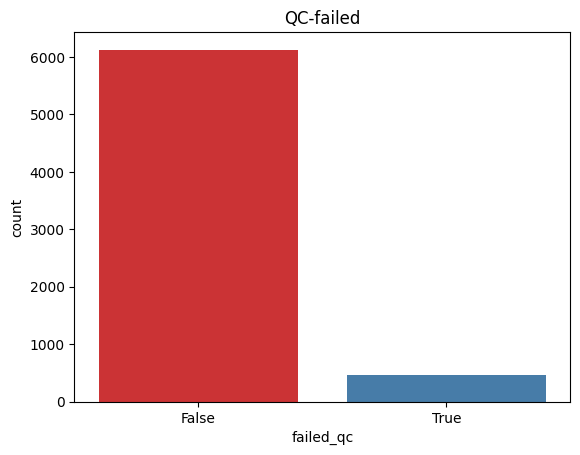

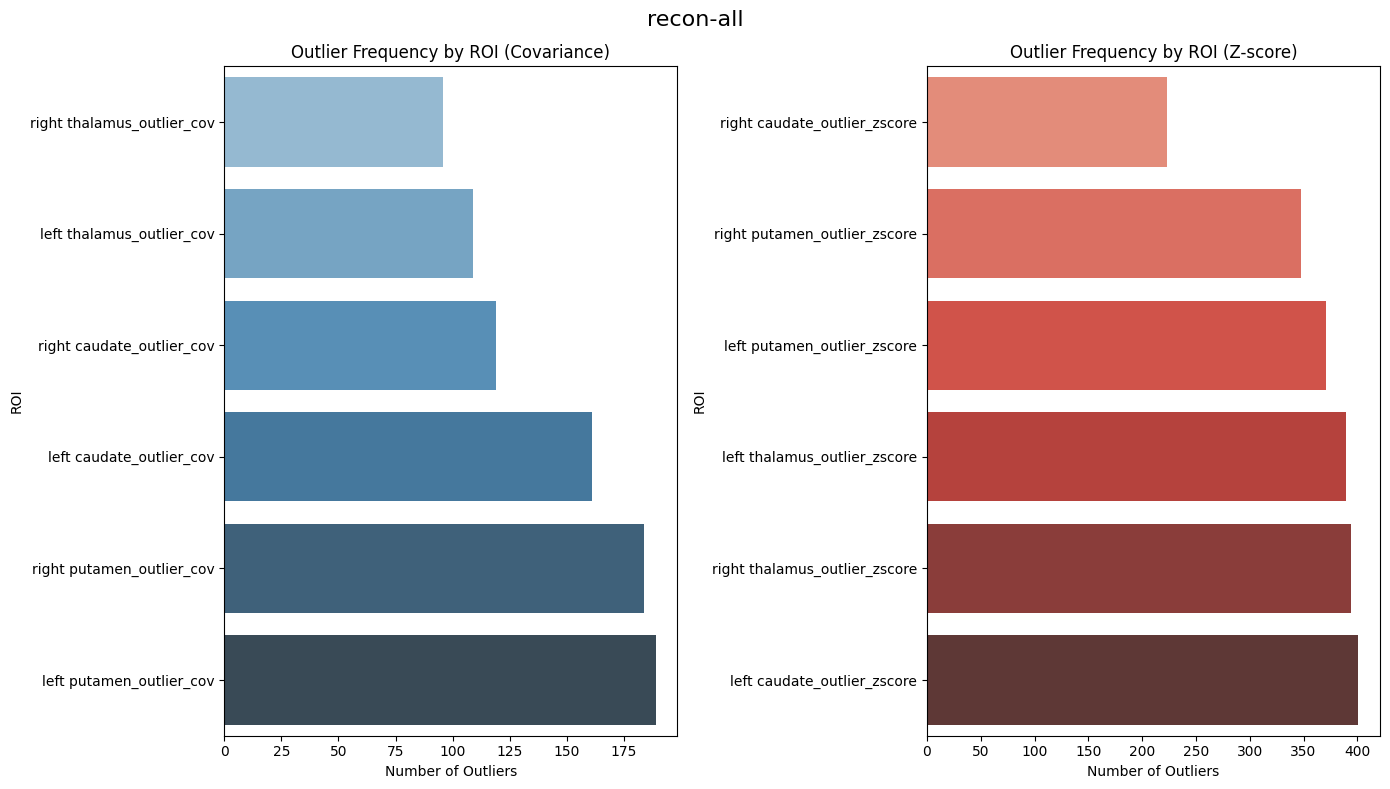

Number of NA ages in minimorph: 0
Number of NA ages in minimorph: 0
Length of dataframe before outlier detection: 1869
failed_qc
False    1837
True       32
Name: count, dtype: int64
Length of dataframe after filtering out failed AXI-T2 QC: 1837 / 1869
Outliers is empty.... 12


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/1398921763.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




N outliers: 762


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/790989012.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/790989012.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




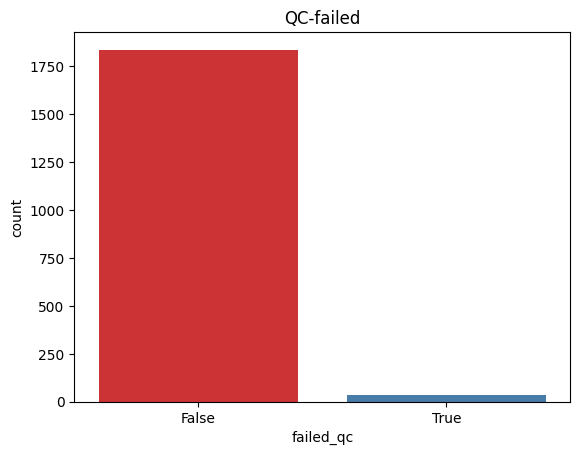

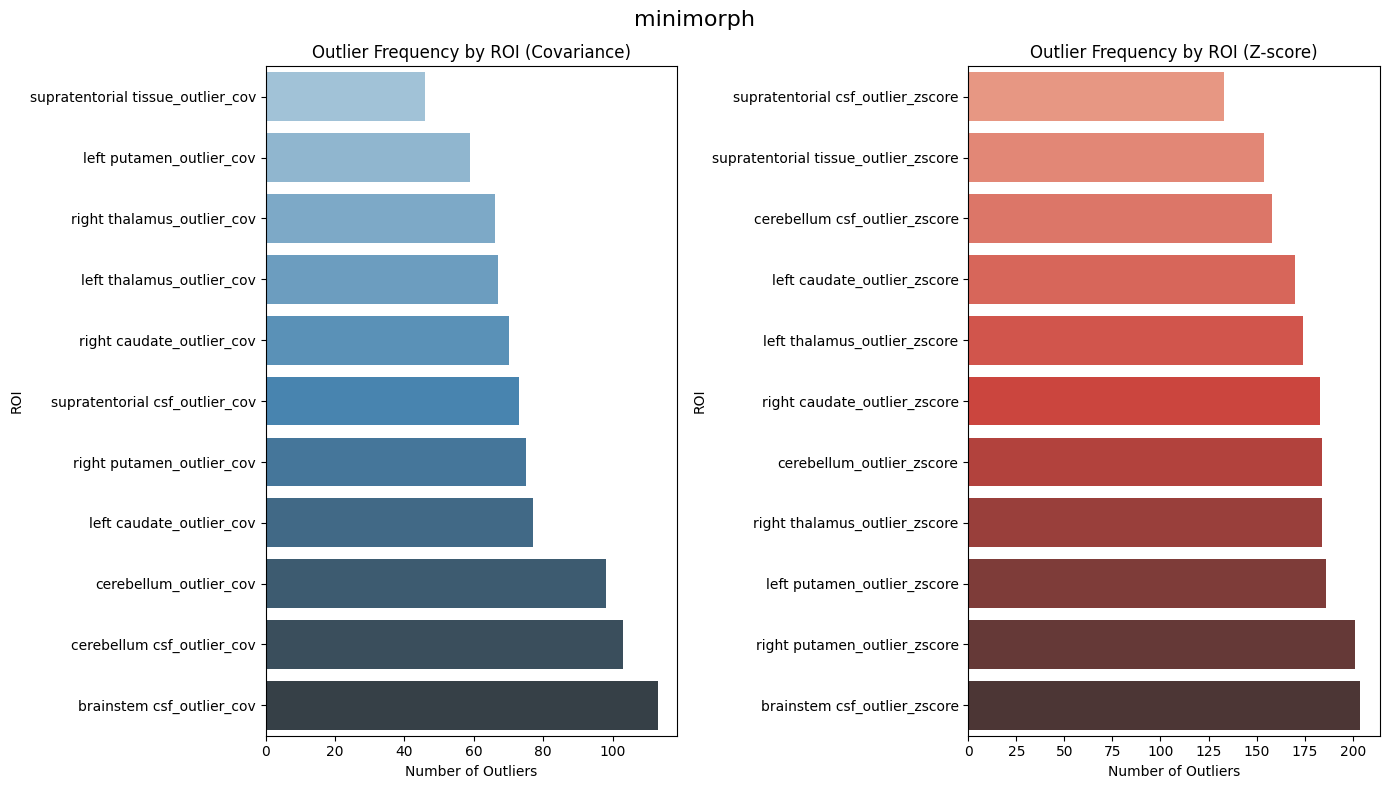

In [387]:
keywords = {"recon-all":[f"{os.path.join(work_dir,'UNITY-recon-all-clinical-0.4.3-volumes.csv')}",f"{os.path.join(work_dir,'UNITY-recon-all-clinical-0.4.4-volumes.csv')}"], 
            "minimorph":[f"{os.path.join(work_dir,'UNITY-minimorph-1.0.11-volumes.csv')}", f"{os.path.join(work_dir,'UNITY-minimorph-1.0.13-volumes.csv')}"]}

for keyword in keywords:

    df = pd.read_csv(keywords[keyword][0])
    df2 = pd.read_csv(keywords[keyword][1])
    #combine both dfs
    df = pd.concat([df, df2], ignore_index=True)
    #reformat column headers
    df.columns = df.columns.str.replace('_', ' ').str.replace('-', ' ').str.lower()
    
    #Make a new age column that has rounded up age
    #handle nans when applying lambda
    #From dfs read in the "age_at_scan_months" and session and subject from , and fill in the age in the df dataframe by matching subject and session ids
    print(f"Number of NA ages in {keyword}: {df['age'].isna().sum()}")
    # Merge to bring in age from demo
    df_merged = df.merge(
        df_demo[['subject', 'session', 'age']], 
        on=['subject', 'session'], 
        how='left', 
        suffixes=('', '_from_demo')
    )

    # Fill missing ages
    df_merged['age'] = df_merged['age'].combine_first(df_merged['age_from_demo'])

    # Optionally drop the helper column
    df_merged = df_merged.drop(columns=['age_from_demo'])
    print(f"Number of NA ages in {keyword}: {df_merged['age'].isna().sum()}")
    
    df_merged['age_in_months'] = df_merged['age'].apply(lambda x: int(np.ceil(x)) if pd.notnull(x) else np.nan)
   
    # df['age_in_months'] = df['age'].apply(lambda x: int(np.ceil(x)))
    df_merged.rename(columns={"icv":"total intracranial"},inplace=True)
    #Print how many NA ages
   

    with open(thresholds, 'r') as f:
        threshold_dictionary = yaml.load(f, Loader=yaml.SafeLoader)
        outlier_thresholds = threshold_dictionary[keyword]['thresholds']
        volumetric_cols = threshold_dictionary[keyword]['volumetric_cols']

    columns_to_keep = ['project', 'subject','session', 'age_in_months', 'sex','acquisition']  + volumetric_cols
    if "input gear v" in df.columns:
        columns_to_keep.insert(6, "input gear v")


    print("Length of dataframe before outlier detection:", len(df))
    passed_qc = pd.read_csv(os.path.join(work_dir, "passedAXI_2025-07-14T23.16.14.094Z.csv"))
    failed_qc = pd.read_csv(os.path.join(work_dir, f"failedAXI_2025-07-14T23.16.14.094Z.csv"))
    #Filter out from the outliers_df those sessions that are in the failed_qc
    #df_filt = df[df['session'].isin(passed_qc['session.label'])]
    

    df_merged["failed_qc"] = df_merged["session"].isin(failed_qc["session.label"])
    df_filt = df_merged[~df_merged["failed_qc"]]

    print(df_merged["failed_qc"].value_counts())
    sns.countplot(x='failed_qc', data=df_merged, palette='Set1')
    plt.title("QC-failed")

    # break

    print("Length of dataframe after filtering out failed AXI-T2 QC:", len(df_filt), "/", len(df_merged))
    
    df_, outliers_df = outlier_detection(df_filt[columns_to_keep], age_column = 'age_in_months',volumetric_columns=volumetric_cols, misc_columns= columns_to_keep, cov_thresholds = outlier_thresholds, zscore_thresholds = outlier_thresholds)
    print("N outliers:", len(outliers_df))
    plot_outlier_trend(outliers_df,keyword)
    outliers_df.to_csv(os.path.join(work_dir,f"{keyword}_outliers.csv"), index=False)

### 1. Get the initial AXI QC (passed/failed) ✅
### 2. Only keep the ones that passed ✅
### 3. Run outlier detection ✅
### 4. Inspect outliers
### 5. Figure out FP rate after visual inspection of the segmentation

In [ ]:
print(df.shape) 
print(outliers_df.shape)

(1869, 29)
(838, 55)


In [87]:
print(outliers_df.age_in_months.mean())
print(df.age_in_months.mean())

9.532219570405728
9.489031567683254


In [89]:
outliers_df_concordance = outliers_df.copy()
#get outliers where n_roi_outliers_cov > 0 and n_roi_outliers_zscore > 0
outliers_df_concordance = outliers_df_concordance[(outliers_df_concordance["n_roi_outliers_cov"] > 0) & (outliers_df_concordance["n_roi_outliers_zscore"] > 0)]
print(outliers_df_concordance.shape)

(502, 55)


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/3471387188.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cov_counts.index, x=cov_counts.values, palette="Blues_d", ax=axes[0])
/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/3471387188.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=zscore_counts.index, x=zscore_counts.values, palette="Reds_d", ax=axes[1])


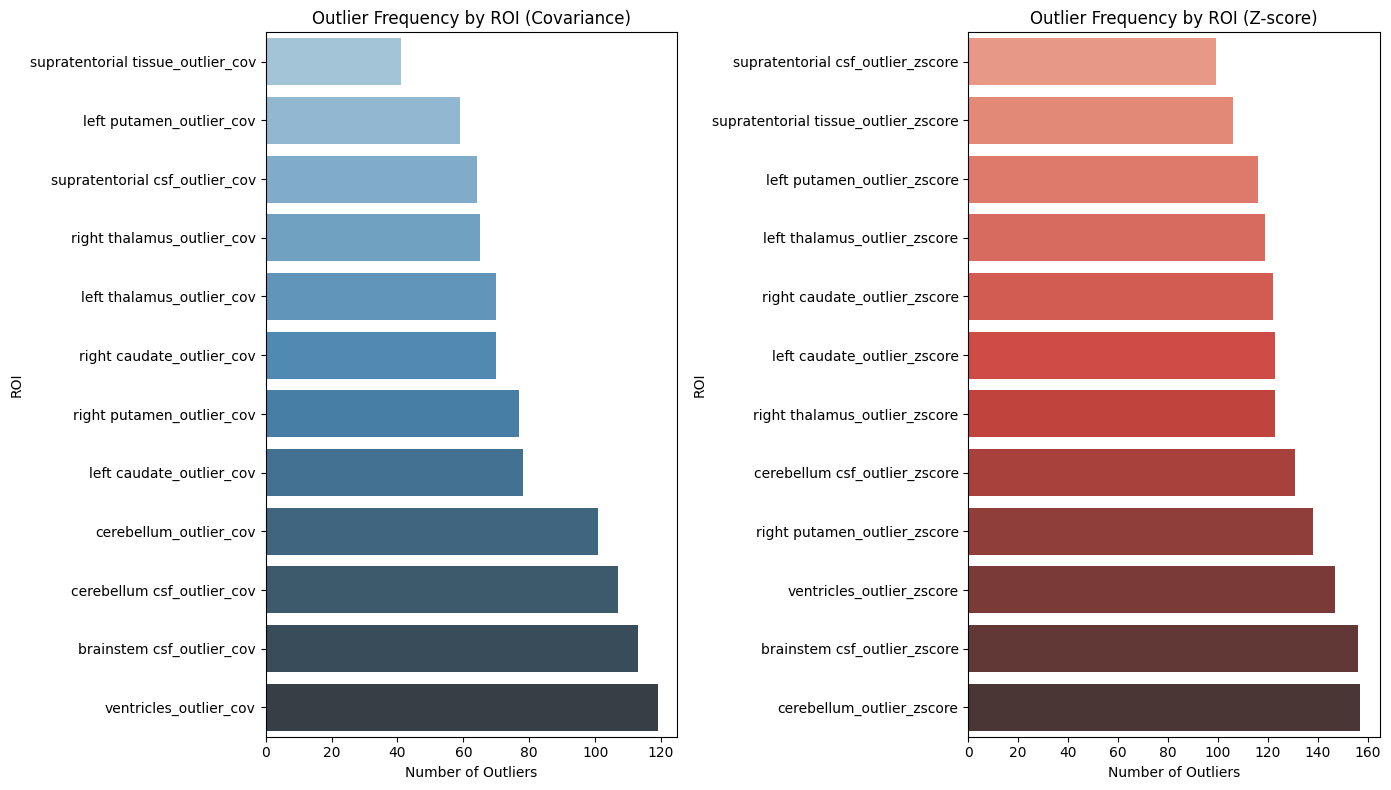

In [92]:
plot_outlier_trend(outliers_df_concordance)

In [ ]:
#qc_cc_uganda = pd.read_csv("/Users/Hajer/unity/GF Sprint25/QC/Uganda_controls_merged_filtered_postQC_QCdata_only_CC.csv")
qc_cc_khula = pd.read_csv(os.path.join(work_dir, "QC/Final_QC_data.csv"))

#combine qc_cc_uganda and qc_cc_khula, they have the same columns

#qc_cc = pd.concat([qc_cc_uganda, qc_cc_khula], axis=0, ignore_index=True)
#qc_cc.to_csv("/Users/Hajer/unity/GF Sprint25/QC/qc_cc_combined.csv", index=False)

#In every column, Replace "Exclude" values with 1 
#qc_cc = qc_cc.replace({"Exclude": 1, "Include": 0})
#If "Exclude" in QC_outcome, then assign Exclude to column "Outcome"

display(qc_cc_khula.head(10))
qc_cc_brainstem = qc_cc_khula[qc_cc_khula['QC_details'].str.contains('brainstem_csf_QC', na=False) ]
qc_cc_brainstem.dicom_age_in_months = qc_cc_brainstem.dicom_age_in_months.str.replace('M', '', regex=True).astype(int)


In [325]:
label_colors = {0: 'green', "Include": 'orange', "Exclude": 'red'}
label_names = {0: 'Good', "Include": 'Include', "Exclude": 'Bad'}

{'Exclude': 'Exclude (N=14)', 'Include': 'Include (N=14)'}


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/3907950041.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



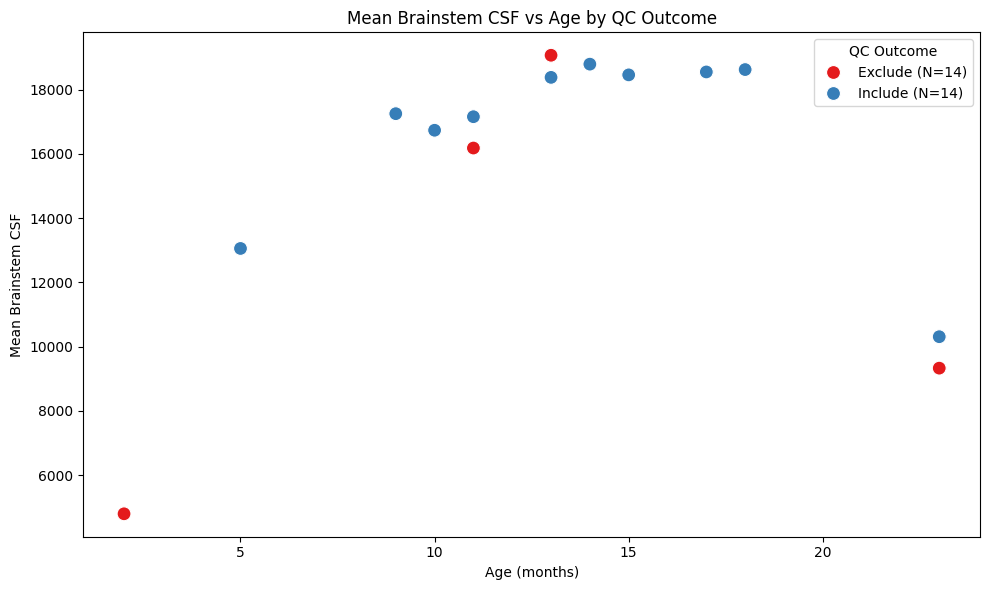

In [327]:

# Create color list for plotting
colors = qc_cc_brainstem['QC_outcome_cat'].map(label_colors)

#Show N of points in each category
n_points = qc_cc_brainstem.groupby('QC_outcome_cat').size()
# Create a mapping: e.g., 'Include' -> 'Include (N=40)'
label_map = {cat: f"{cat} (N={n})" for cat, n in n_points.items()}
print(label_map)
qc_cc_brainstem['QC_outcome_cat_label'] = qc_cc_brainstem['QC_outcome_cat'].map(label_map)

# Group by age and QC outcome, compute mean brainstem_csf
grouped = qc_cc_brainstem.groupby(['dicom_age_in_months', 'QC_outcome_cat_label'])['brainstem_csf'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='dicom_age_in_months',
    y='brainstem_csf',
    hue='QC_outcome_cat_label',
    palette='Set1',  # Optional: choose a palette
    s=100            # Optional: size of points
)

plt.title('Mean Brainstem CSF vs Age by QC Outcome')
plt.xlabel('Age (months)')
plt.ylabel('Mean Brainstem CSF')
plt.legend(title='QC Outcome')
plt.tight_layout()
plt.show()

In [ ]:
# Filter rows that contain 'cerebellum_QC' in QC_details
qc_cc_cerebellum = qc_cc_khula[qc_cc_khula['QC_details'].str.contains('cerebellum_QC', na=False) ]
qc_cc_cerebellum


In [308]:
qc_cc_cerebellum['dicom_age_in_months'] = pd.to_numeric(qc_cc_cerebellum['dicom_age_in_months'], errors='coerce')


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/4225302863.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [322]:
qc_cc_cerebellum.QC_outcome_cat_label.value_counts()

QC_outcome_cat_label
Exclude (N=25)    10
Include (N=10)    10
Name: count, dtype: int64

In [338]:
qc_minimorph= pd.read_excel("/Users/Hajer/unity/GF Sprint25/QC/MiniMorph_QC_25032025.xlsx")


In [320]:
print(qc_cc_cerebellum.columns)
grouped = qc_cc_cerebellum.groupby(['dicom_age_in_months', 'QC_outcome_cat_label'])['cerebellum'].mean().reset_index()
print(grouped)

Index(['subject', 'session', 'dicom_age_in_months', 'sex', 'acquisition',
       'template_age', 'supratentorial_tissue', 'supratentorial_csf',
       'ventricles', 'cerebellum', 'cerebellum_csf', 'brainstem',
       'brainstem_csf', 'left_thalamus', 'left_caudate', 'left_putamen',
       'left_globus_pallidus', 'right_thalamus', 'right_caudate',
       'right_putamen', 'right_globus_pallidus', 'posterior_callosum',
       'mid_posterior_callosum', 'central_callosum', 'mid_anterior_callosum',
       'anterior_callosum', 'icv', 'id', 'sub_label', 'ses_label',
       'analysis_id', 'merge_label', 'age_months', 'QC_details', 'QC',
       'QC_outcome', 'QC_comment', 'QC_details.1', 'QC.1', 'QC_outcome.1',
       'QC_outcome_cat', 'QC_comment.1', 'QC_outcome_cat_label'],
      dtype='object')
Empty DataFrame
Columns: [dicom_age_in_months, QC_outcome_cat_label, cerebellum]
Index: []


{'Exclude': 'Exclude (N=25)', 'Include': 'Include (N=10)'}


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/542928528.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_96030/542928528.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



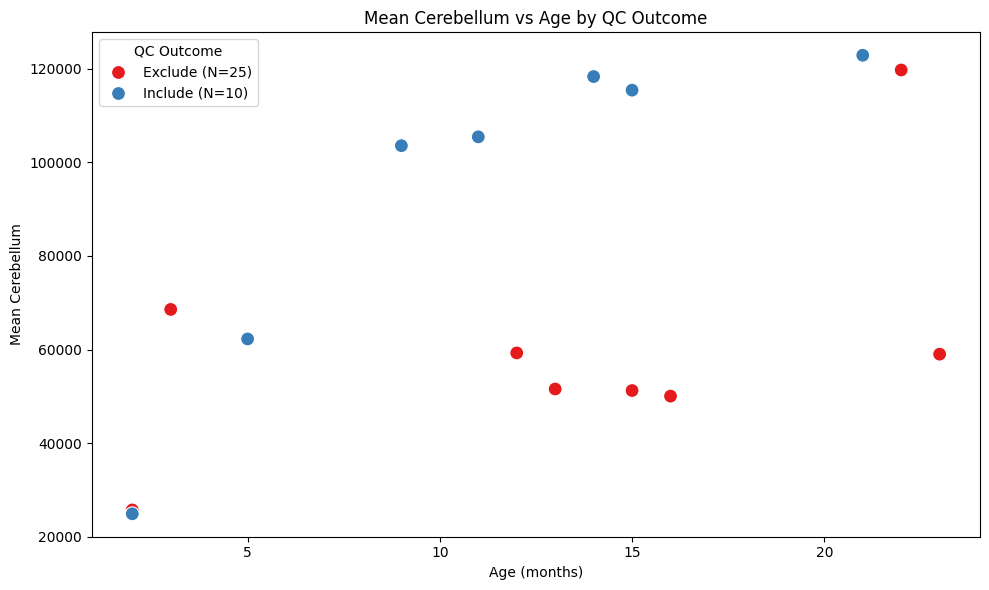

In [328]:
qc_cc_cerebellum = qc_cc_khula[qc_cc_khula['QC_details'].str.contains('cerebellum_QC', na=False) ]
qc_cc_cerebellum.dicom_age_in_months = qc_cc_cerebellum.dicom_age_in_months.str.replace('M', '', regex=True).astype(int)

# Create color list for plotting
colors = qc_cc_cerebellum['QC_outcome_cat'].map(label_colors)

#Show N of points in each category
n_points = qc_cc_cerebellum.groupby('QC_outcome_cat').size()
# Create a mapping: e.g., 'Include' -> 'Include (N=40)'
label_map = {cat: f"{cat} (N={n})" for cat, n in n_points.items()}
print(label_map)
qc_cc_cerebellum['QC_outcome_cat_label'] = qc_cc_cerebellum['QC_outcome_cat'].map(label_map)

# Group by age and QC outcome, compute mean cerebellum
grouped = qc_cc_cerebellum.groupby(['dicom_age_in_months', 'QC_outcome_cat_label'])['cerebellum'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='dicom_age_in_months',
    y='cerebellum',
    hue='QC_outcome_cat_label',
    palette='Set1',  # Optional: choose a palette
    s=100            # Optional: size of points
)

plt.title('Mean Cerebellum vs Age by QC Outcome')
plt.xlabel('Age (months)')
plt.ylabel('Mean Cerebellum')
plt.legend(title='QC Outcome')
plt.tight_layout()
plt.show()

In [330]:
regions =  [
    'supratentorial_tissue', 'supratentorial_csf', 'ventricles',
    'cerebellum', 'cerebellum_csf', 'brainstem', 'brainstem_csf',
    'left_thalamus', 'left_caudate', 'left_putamen', 'left_globus_pallidus',
    'right_thalamus', 'right_caudate', 'right_putamen', 'right_globus_pallidus',
    'posterior_callosum', 'mid_posterior_callosum', 'central_callosum',
    'mid_anterior_callosum', 'anterior_callosum', 'icv'
]

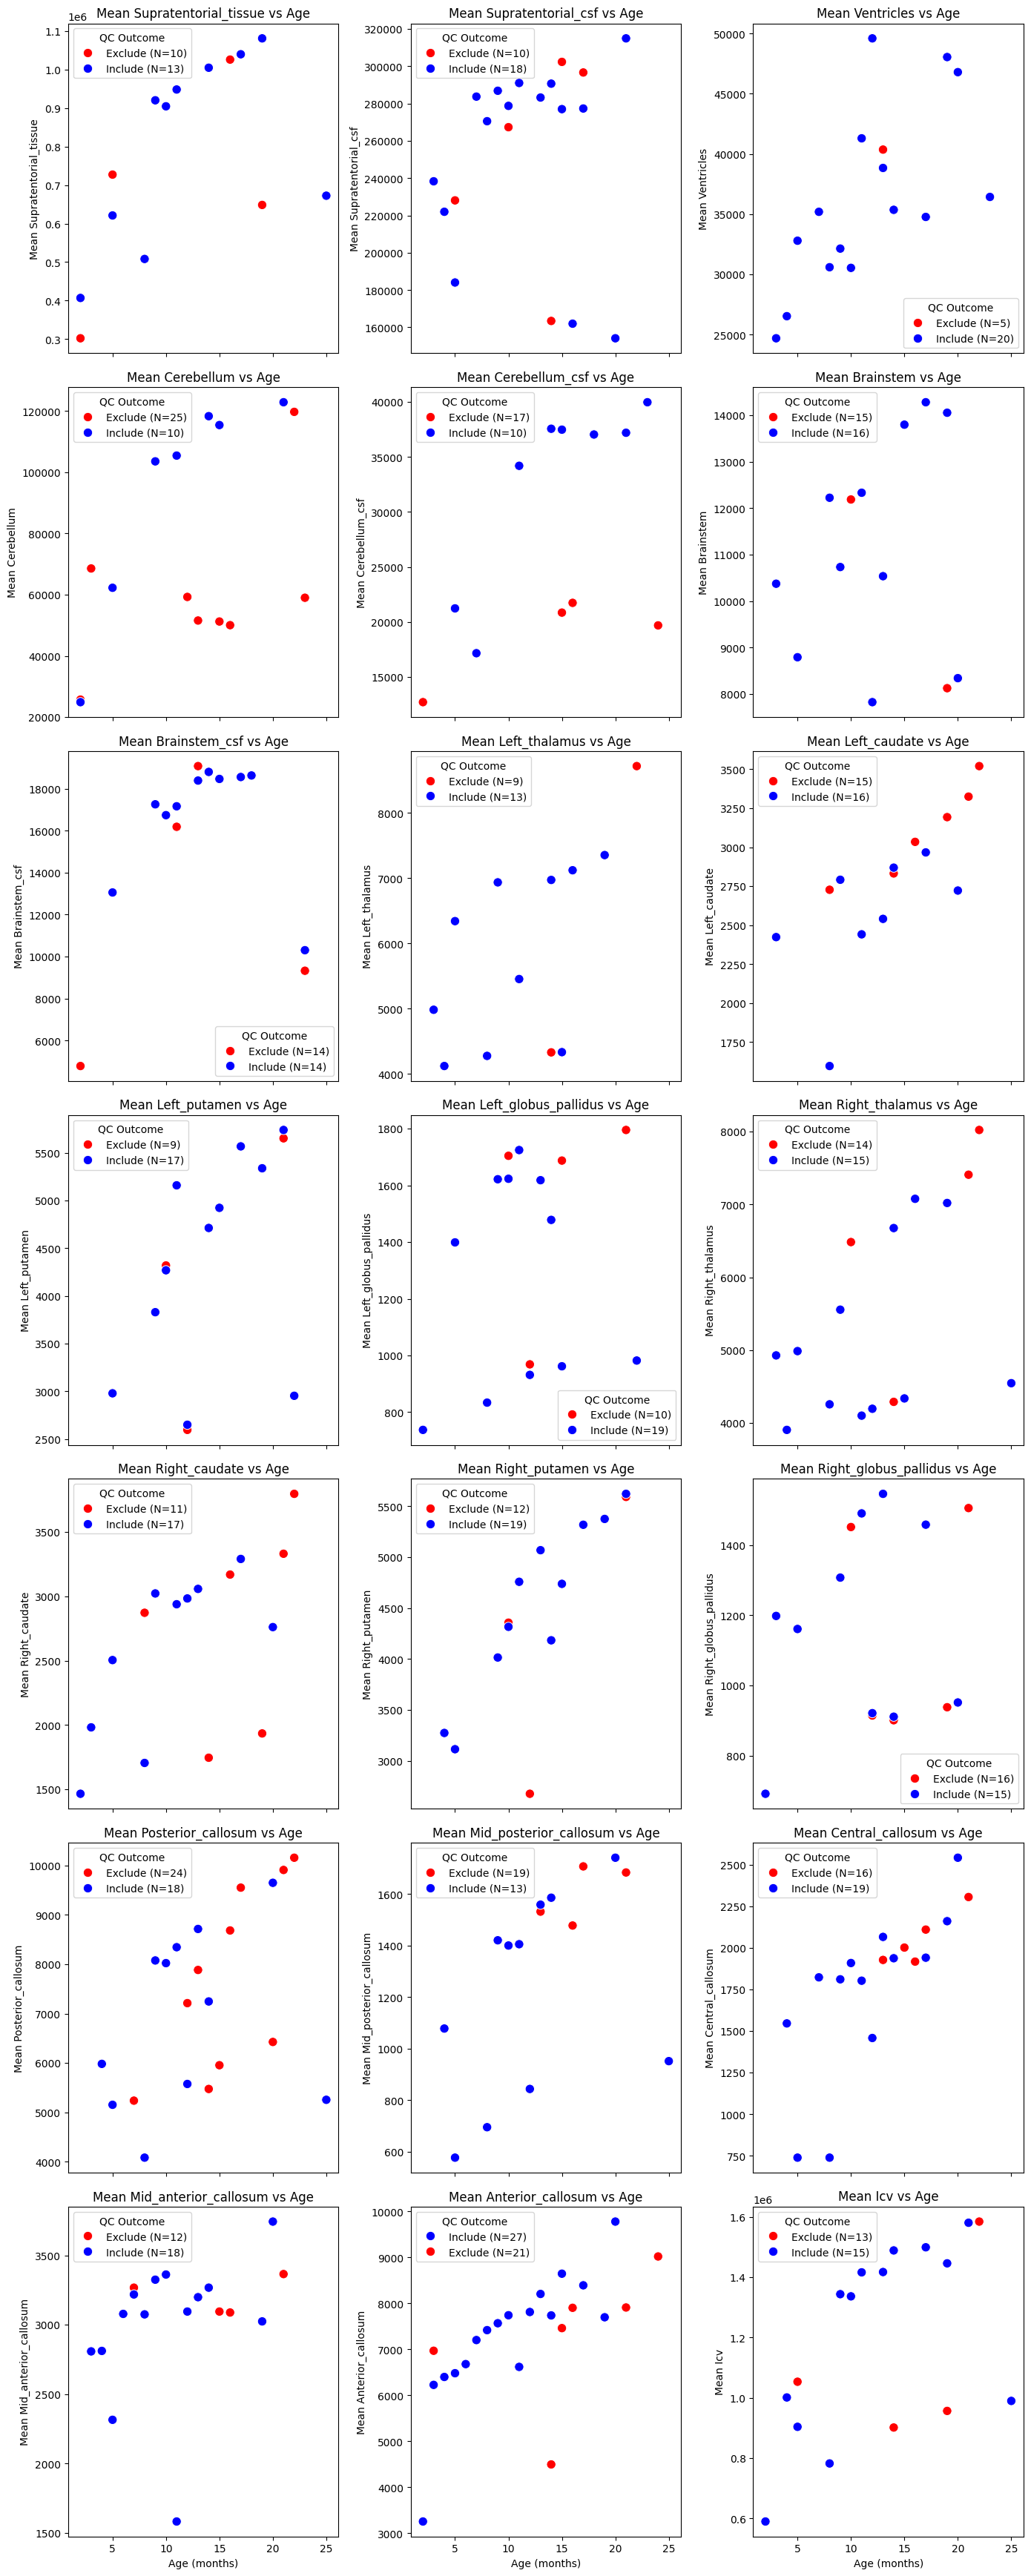

In [ ]:
# import grid size
impotr math
n = len(regions)
ncols = 3
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 5), sharex=True)
axes = axes.flatten()

qc_categories = ['Include', 'Exclude'] 
qc_palette = {
    'Include': 'blue',
    'Exclude': 'red'
}

for i, region in enumerate(regions):
    ax = axes[i]

    qc_col = f"{region}_QC"
    
    # Filter for subjects where this region was flagged
    region_df = qc_cc_khula[qc_cc_khula['QC_details'].str.contains(qc_col, na=False)].copy()
    
    # Clean age column
    region_df['dicom_age_in_months'] = region_df['dicom_age_in_months'].str.replace('M', '', regex=True).astype(int)
    
    # Count labels only for known categories (to avoid issues with missing ones)
    n_points = region_df['QC_outcome_cat'].value_counts().reindex(qc_categories).fillna(0).astype(int)

    # Map to fixed labels even if count is 0
    label_map = {cat: f"{cat} (N={n_points[cat]})" for cat in qc_categories}
    region_df['QC_outcome_cat_label'] = region_df['QC_outcome_cat'].map(label_map)

    label_palette = {label_map[cat]: qc_palette[cat] for cat in qc_categories if cat in label_map}

    
    # Group and average
    grouped = region_df.groupby(['dicom_age_in_months', 'QC_outcome_cat_label'])[region].mean().reset_index()
    
    # Plot
    sns.scatterplot(
        data=grouped,
        x='dicom_age_in_months',
        y=region,
        hue='QC_outcome_cat_label',
        palette=label_palette,
        s=80,
        ax=ax
    )
    ax.set_title(f'Mean {region.capitalize()} vs Age')
    ax.set_xlabel('Age (months)')
    ax.set_ylabel(f'Mean {region.capitalize()}')

    # Add legend explicitly for every plot
    ax.legend(title='QC Outcome')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()